In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

from sklearn import metrics

import scipy
from scipy import sqrt

import seaborn as sns
sns.set_style("white")

import sys
sys.path.append('../../modules/')
from Processors import *

## Skim size, Acceptance, xSec and luminosity

In [2]:
from DataInfo import *

### Calculate FOM

In [3]:
from helper import *

## Get Data

In [4]:
loc = '../../../data_n/'

masses = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]
backgroundLabels = ['TT', 'WJets']

signalData = []
backgroundData = []

for mass in masses:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(mass) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"))


# drop columns without header
for mass, signal_data in zip(masses, signalData):
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    signal_data['gen_label'] = str(mass)

for label, background_data in zip(backgroundLabels, backgroundData):
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    background_data['gen_label'] = label

allSignalData = mergeDataFrame(signalData)
allBackgroundData = mergeDataFrame(backgroundData)

for i in range(len(masses)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), masses[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


In [5]:
dropMctMatch = True

mIdx = 5

if dropMctMatch:
    # drop signal that does not match thing
    allSignalData = allSignalData[allSignalData['gen_mctMatch']]

allData = allSignalData.append(allBackgroundData, ignore_index=True)
allLabels = np.append(np.ones(len(allSignalData)),np.zeros(len(allBackgroundData)))

In [6]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(allData, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(allData, p) #Calculate energy and absolute momentum
    
moveToCartesian(allData, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(allData, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(allData, allData['t_1_pT'], allData['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

## select train variables

In [7]:
genFeatures = [var for var in allData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allData.columns if var not in genFeatures] #Reconstructed features; ok for training

In [8]:
pTEtaPhi = [var for var in trainFeatures for x in ['phi', 't_1_mass'] if x in var] # 'pT', 'eta', 
other = [var for var in trainFeatures for x in ['diH_kinFit_prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]# + other]

In [9]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

In [10]:
classTrainFeatures = fsFeatures

# minimalistic:
#classTrainFeatures = ['b_0_eta', 'b_0_mass', 'b_0_csv'] + \
#                     ['b_1_eta', 'b_1_mass', 'b_1_csv'] + \
#                     ['mPT_pT'] + \
#                     ['h_tt_svFit_mass', 'h_tt_mass'] + \
#                     ['h_bb_mass'] + \
#                     ['diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob']
print("Training on {} features {}". format(len(classTrainFeatures), classTrainFeatures))

Training on 65 features ['t_0_pT', 't_0_eta', 't_0_mass', 't_1_pT', 't_1_eta', 'b_0_pT', 'b_0_eta', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'h_tt_pT', 'h_tt_eta', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


In [11]:
removeFromTrain = []

allDataTrainFeatures = allData

for remove in removeFromTrain:
    allLabels = allLabels[allDataTrainFeatures['gen_label'] != str(remove)]
    allDataTrainFeatures = allDataTrainFeatures[allDataTrainFeatures['gen_label'] != str(remove)]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(allDataTrainFeatures, allLabels, test_size=0.2, random_state=2345)

allDataTrainFeatures = allDataTrainFeatures[classTrainFeatures]

X_train, X_test, y_train, y_test = train_test_split(allDataTrainFeatures, np.copy(allLabels), test_size=0.2, random_state=2345)
for var in (X_train, X_test, X_train_full, X_test_full):
    var.reset_index(inplace=True, drop=True)

## Remove points who fail conversion to float32

In [12]:
def cleanData(X, y):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    temp = X[classTrainFeatures]
    over  = (temp > np.finfo(np.float32).max)
    under = (temp < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)
    
    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    y = y[np.logical_not(selecting)]#.astype('float32')
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X, y

In [13]:
X_train, y_train = cleanData(X_train, y_train)
X_test , y_test  = cleanData(X_test , y_test )
X_train_full, y_train_full = cleanData(X_train_full, y_train_full)
X_test_full , y_test_full  = cleanData(X_test_full , y_test_full )

In [14]:
scale = len(allBackgroundData)/len(allSignalData)

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale
weights_test[y_test == 1] = scale

In [15]:
%%time
# fit model on training data
model = xgb.XGBClassifier(random_state=1337, silent=False,
                          scale_pos_weight=scale,
                          objective='binary:logistic',
                          n_estimators=100, eval_metric='auc',
                          max_depth=4,
                          n_jobs=8) #NOTE: number of threads to execute
model.fit(X_train, y_train)

CPU times: user 4min 54s, sys: 608 ms, total: 4min 54s
Wall time: 49.9 s


In [16]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [17]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy           : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=y_test)
print("Accuracy signal    : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=np.logical_not(y_test))
print("Accuracy background: {:10}%".format(accuracy * 100.0))

Accuracy           : 96.45273200346921%
Accuracy signal    : 94.98910675381264%
Accuracy background: 96.49263483012592%


In [18]:
print(model.score(X_train, y_train, sample_weight=weights_train))
print(model.score(X_test, y_test, sample_weight=weights_test))

0.973980693759
0.957670315003


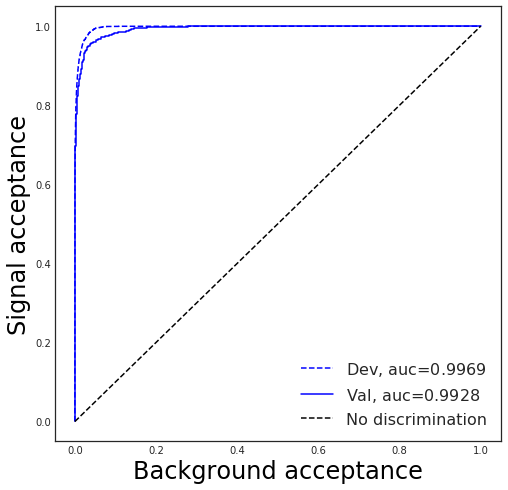

In [19]:
plt.figure(figsize=[8, 8])
plt.plot(*metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### Heavy and light mass diference (< 500)

In [20]:
train_bkg  = X_train_full['gen_label'].map(lambda x: x in backgroundLabels)
train_sig1 = X_train_full['gen_label'].map(lambda x: x in map(str, masses[mIdx:]))
train_sig2 = X_train_full['gen_label'].map(lambda x: x in map(str, masses[:mIdx]))

test_bkg  = X_test_full['gen_label'].map(lambda x: x in backgroundLabels)
test_sig1 = X_test_full['gen_label'].map(lambda x: x in map(str, masses[mIdx:]))
test_sig2 = X_test_full['gen_label'].map(lambda x: x in map(str, masses[:mIdx]))

train1 = train_bkg | train_sig1
test1  = test_bkg  | test_sig1
train2 = train_bkg | train_sig2
test2  = test_bkg  | test_sig2

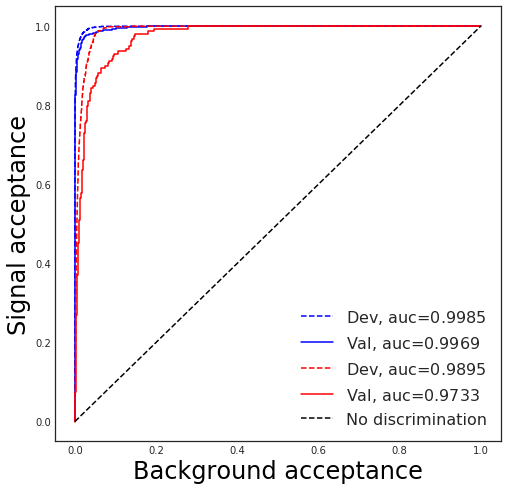

In [21]:
plt.figure(figsize=[8, 8])

plt.plot(*metrics.roc_curve(y_train[train1], model.predict_proba(X_train)[:,1][train1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train[train1], model.predict_proba(X_train)[:,1][train1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test[test1], model.predict_proba(X_test)[:,1][test1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test[test1], model.predict_proba(X_test)[:,1][test1])),
         color='b')

plt.plot(*metrics.roc_curve(y_train[train2], model.predict_proba(X_train)[:,1][train2])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train[train2], model.predict_proba(X_train)[:,1][train2])),
         color='r', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test[test2], model.predict_proba(X_test)[:,1][test2])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test[test2], model.predict_proba(X_test)[:,1][test2])),
         color='r')

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

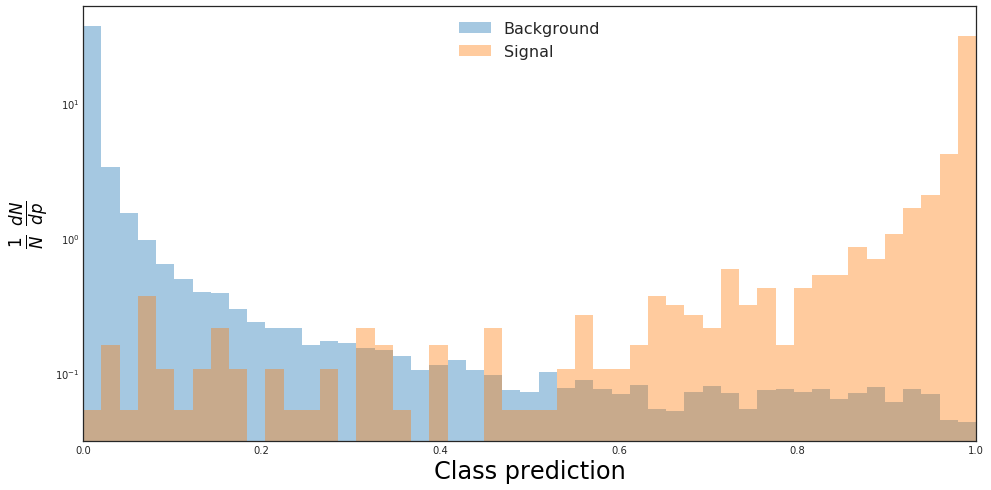

In [22]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True, 'bins' : np.linspace(0, 1, 50)}
plt.figure(figsize=(16, 8))
a, b = y_test, model.predict_proba(X_test)[:,1]
signalThing, backgroundThing = b[a.astype(bool)], b[np.logical_not(a.astype(bool))]
sns.distplot(backgroundThing, label='Background', **params)
sns.distplot(signalThing, label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
plt.yscale('log', nonposy='clip')
plt.show()

In [23]:
backgroundTestData, signalTestData = [], []
backgroundScore, signalScore = [], []

for label in backgroundLabels:
    selection = X_test_full['gen_label'] == label
    var = X_test[selection]
    
    backgroundTestData.append(var)
    backgroundScore.append(model.predict_proba(var[classTrainFeatures])[:,1])
    
trainMasses = masses[:]
for mass in removeFromTrain: trainMasses.remove(mass)
    
for mass in trainMasses:
    selection = X_test_full['gen_label'] == str(mass)
    var = X_test[selection]
    
    signalTestData.append(var)
    signalScore.append(model.predict_proba(var[classTrainFeatures])[:,1])
    print(mass, np.average(model.predict_proba(var[classTrainFeatures])[:,1]))
    
for mass in removeFromTrain:
    selection = allData['gen_label'] == str(mass)
    var = allData[selection][classTrainFeatures]
    
    signalTestData.append(var)
    signalScore.append(model.predict_proba(var[classTrainFeatures])[:,1])
    print(mass, np.average(model.predict_proba(var[classTrainFeatures])[:,1]))
    
var = sorted(zip(trainMasses + removeFromTrain, signalTestData, signalScore))
signalTestData, signalScore = [i[1] for i in var], [i[2] for i in var]

260 0.78359
270 0.801007
280 0.680668
300 0.716126
320 0.637882
400 0.787766
500 0.954147
550 0.972404
600 0.980997
700 0.979172


In [24]:
def FOMAfterCut(p):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(len(data[(scores > p)]) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(len(data[(scores > p)]) / .2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)))

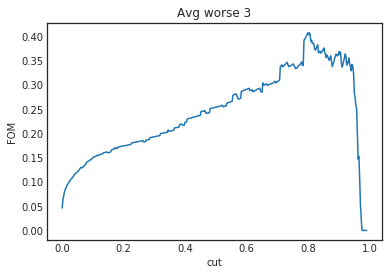

In [25]:
x = np.linspace(0,.99,400)
y = []
for i in x:
    y.append(FOMAfterCut(i))

plt.xlabel('cut')
plt.ylabel('FOM')
plt.title('Avg worse 3')
plt.plot(x, y)
plt.show()

In [26]:
def FOMAfterCutWorse(p):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(len(data[(scores > p)]) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(len(data[(scores > p)])/.2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), min)

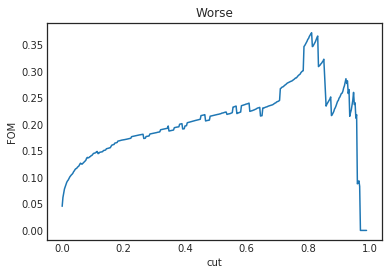

In [27]:
x = np.linspace(0,.99,400)
y = []
for i in x:
    y.append(FOMAfterCutWorse(i))

plt.xlabel('cut')
plt.ylabel('FOM')
plt.title('Worse')
plt.plot(x, y)
plt.show()

In [28]:
def FOMAfterCutForMass(p, a):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(len(data[(scores > p)]) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(len(data[(scores > p)]) / .2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), lambda x: x[a])

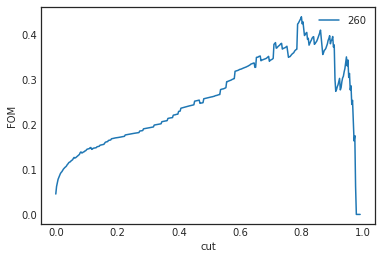

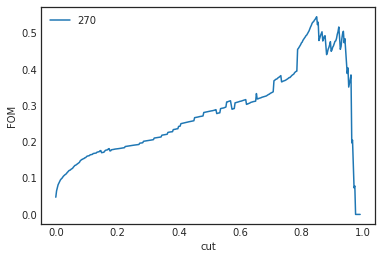

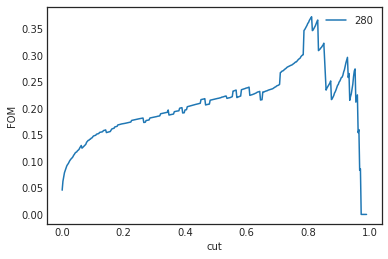

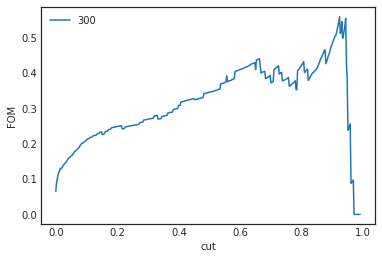

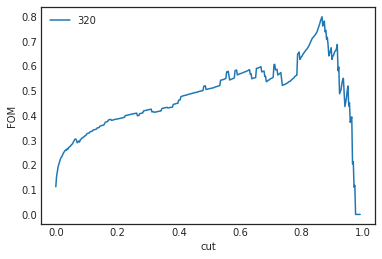

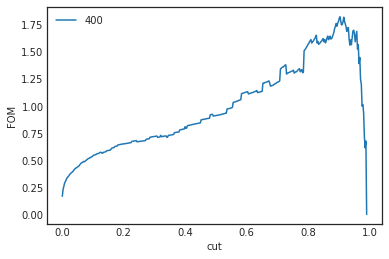

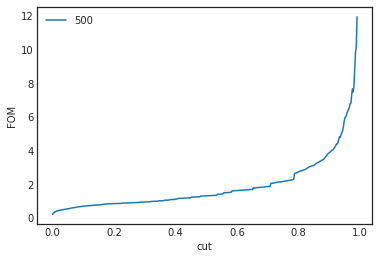

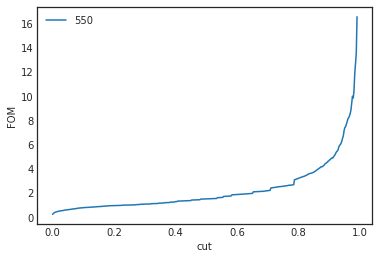

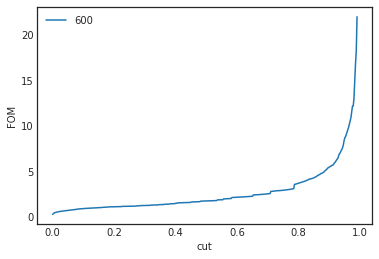

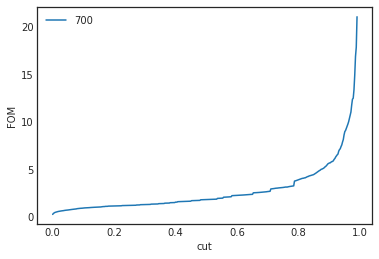

In [29]:
for j, mass in enumerate(masses):
    x = np.linspace(0,.99,400)
    y = []
    for i in x:
        y.append(FOMAfterCutForMass(i, j))

    plt.xlabel('cut')
    plt.ylabel('FOM')

    plt.plot(x, y, label=mass)
    plt.legend()#loc='best', fontsize=16)
    plt.show()

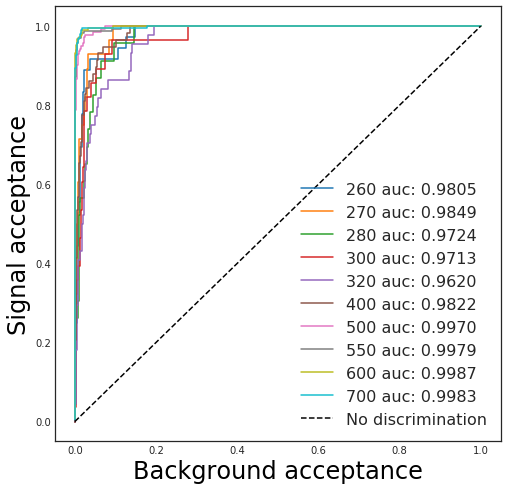

In [30]:
plt.figure(figsize=[8, 8])

for mass, signal in zip(masses, signalTestData):
    signalAndBackground = mergeDataFrame(backgroundTestData + [signal])
    backgroundSize = sum([len(i) for i in backgroundTestData])
    signalAndBackgroundLabel = np.append(np.zeros(backgroundSize, dtype=int), np.ones(len(signal), dtype=int))
    
    plt.plot(*metrics.roc_curve(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,1])[:2],
             label=str(mass) + ' auc: {:.4f}'.format(
             metrics.roc_auc_score(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,1])))

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
#plt.xlim(0.,0.4)
#plt.ylim(0.6,1.)
plt.show()

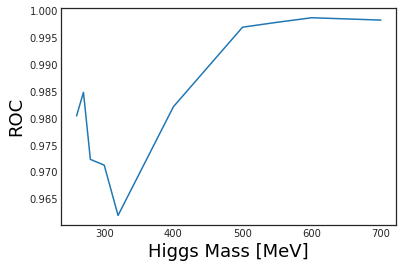

In [31]:
x,y = [], []
for mass, signal in zip(masses, signalTestData):
    signalAndBackground = mergeDataFrame(backgroundTestData + [signal])
    backgroundSize = sum([len(i) for i in backgroundTestData])
    signalAndBackgroundLabel = np.append(np.zeros(backgroundSize, dtype=int), np.ones(len(signal), dtype=int))
    x.append(mass)
    y.append(metrics.roc_auc_score(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,1]))
plt.plot(x,y)
plt.xlabel('Higgs Mass [MeV]', color='black', fontSize=18)
plt.ylabel('ROC', color='black', fontSize=18)
plt.show()